# All imports necessary

In [1]:
import string

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [75]:
import seaborn as sns

In [4]:
sns.set(color_codes=True)

In [27]:
sns.set(font_scale=1.5)

In [8]:
from tqdm.autonotebook import tqdm

In [6]:
tqdm.pandas()

In [7]:
%matplotlib inline

# Auxiliary methods

In [9]:
def filter_by_subcorpus(data_root_folder, subcorpus_name):
    data_folders = [
        os.path.join(data_root_folder, 'data', folder, subfolder)
        for folder in tqdm(os.listdir(os.path.join(data_root_folder, 'data')), desc="Read folders: ")
        for subfolder in os.listdir(os.path.join(data_root_folder, 'data', folder))
    ]
    mask = []
    for folder in tqdm(data_folders, desc="Filter folders: "):
        with open(os.path.join(folder, 'en.met'), 'r', encoding='utf-8') as myfile:
            mask.append(subcorpus_name in myfile.read().replace('\n', ''))
    return np.array(data_folders)[mask]

In [10]:
def get_raw_texts(folders, cache_folder):
    if not os.path.exists(os.path.join(cache_folder, 'en.raw.extracted.npy')):
        texts = []
        for folder in tqdm(folders, desc="Read files: "):
            with open(os.path.join(folder, 'en.raw'), 'r', encoding='utf-8') as myfile:
                texts.append(myfile.read().replace('\n', ''))
        np.save(os.path.join(cache_folder, 'en.raw.extracted.npy'), texts)
        return texts
    else:
        return np.load(os.path.join(cache_folder, 'en.raw.extracted.npy'))

In [11]:
def get_tagged_texts_as_pd(folders, cache_folder):
    if not os.path.exists(os.path.join(cache_folder, 'en.tags.pd.extracted.csv')):
        columns=[
            'token',
            'pos_tag',
            'lemma',
            'ner_tag',
            'word_net_sense_number',
            'verb_net_roles',
            'semantic_relation',
            'animacy_tag',
            'super_tag',
            'lambda_dsr'
        ]
        tagged_dfs = []
        
        for folder in tqdm(folders, desc="Read files: "):
            tagged_text_df = pd.read_csv(
                os.path.join(folder, 'en.tags'),
                delimiter='\t',
                encoding='utf-8',
                names=columns
            )
            tagged_dfs.append(tagged_text_df)
        df = pd.concat(tagged_dfs, ignore_index=True, sort=False)
        # cache the file
        df.to_csv(os.path.join(cache_folder, 'en.tags.pd.extracted.csv'), index=False)
        return df
    else:
        df = pd.read_csv(os.path.join(cache_folder, 'en.tags.pd.extracted.csv'))
        return df

In [12]:
def filtrations(df):
    # filtrations and preprocessing
    tqdm.pandas(desc="Punctuation: ")
    
    df = df[df.lemma.progress_apply(lambda lemma: str(lemma) not in string.punctuation)]
    df = df[df.ner_tag != '[]']
    df.word_net_sense_number = df.word_net_sense_number.astype(np.int64)
    
    tqdm.pandas(desc="Target tags: ")
    df.ner_tag = df.ner_tag.progress_apply(lambda x: str(x).split('-')[0] if str(x) != 'O' else str(x))
    tqdm.pandas(desc="")
    
    return df

In [13]:
def additional_features(df):
    # additional features
    tqdm.pandas(desc="NER tagged: ")
    df['ner_tagged'] = df.ner_tag.progress_apply(lambda x: int(str(x) != 'O'))
    
    tqdm.pandas(desc="Semantic relation: ")
    df['semantic_relation_tagged'] = df.semantic_relation.progress_apply(lambda x: int(str(x) != 'O'))
    
    tqdm.pandas(desc="Animacy tagged: ")
    df['animacy_tagged'] = df.animacy_tag.progress_apply(lambda x: int(str(x) != 'O'))
    
    tqdm.pandas(desc="Lambda-DSR len: ")
    df['lambda_dsr_len'] = df.lambda_dsr.progress_apply(lambda x: len(str(x)))
    
    tqdm.pandas(desc="Word sense: ")
    df['word_sense_exists'] = df.word_net_sense_number.progress_apply(lambda x: int(int(x) > 0))

    tqdm.pandas(desc="Is title: ")
    df['is_title'] = df.token.progress_apply(lambda x: int(str(x).istitle()))
    
    tqdm.pandas(desc="Contains digits: ")
    df['contains_digits'] = df.token.progress_apply(lambda x: int(not str(x).isalpha()))
    
    tqdm.pandas(desc="Word len: ")
    df['word_len'] = df.token.progress_apply(lambda x: len(str(x)))
    
    tqdm.pandas(desc="")
    
    return df

# Read the data

## Where are we at the moment

In [14]:
! pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
! ls -alth ../data/datasets/gmb-2.2.0/

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Get the subset of folders for target subcorpus (Voice of America)

In [16]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

## Read subcorpus

In [18]:
tagged_texts_as_pd = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

## Do a bit of preprocessing

In [19]:
tagged_texts_as_pd_f = filtrations(tagged_texts_as_pd)

## Add new features describing words

In [20]:
tagged_texts_as_pd_f_add_f = additional_features(tagged_texts_as_pd_f)

## Take a bit of a look into the data

In [61]:
tagged_texts_as_pd_f_add_f.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
token,Thousands,of,demonstrators,have,marched,through,London,to,protest,the,war,in,Iraq,and,demand,the,withdrawal,of,British,troops
pos_tag,NNS,IN,NNS,VBP,VBN,IN,NNP,TO,VB,DT,NN,IN,NNP,CC,VB,DT,NN,IN,JJ,NNS
lemma,thousand,of,demonstrator,have,march,through,london,to,protest,the,war,in,iraq,and,demand,the,withdrawal,of,uk,troops
ner_tag,O,O,O,O,O,O,geo,O,O,O,O,O,geo,O,O,O,O,O,gpe,O
word_net_sense_number,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1
verb_net_roles,[],[],[],[],[Theme],[],[],[],"[Theme,Agent]",[],[],[],[],[],"[Recipient,Agent]",[],[],[],[],[]
semantic_relation,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,of,O
animacy_tag,Human,O,Human,O,O,O,Place,O,O,O,Non-concrete,O,Place,O,O,O,Non-concrete,O,Human,Human
super_tag,N,(NP\NP)/NP,N,(S[dcl]\NP)/(S[pt]\NP),S[pt]\NP,((S[pt]\NP)\(S[pt]\NP))/NP,N,(S[to]\NP)/(S[b]\NP),(S[b]\NP)/NP,NP/N,N,(NP\NP)/NP,N,conj,(S[b]\NP)/NP,NP/N,N,(NP\NP)/NP,N/N,N
lambda_dsr,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n...","lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...","lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat...","lam(v1,lam(v2,lam(v3,app(app(v1,v2),lam(v4,mer...","lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[...","lam(v1,lam(v2,lam(v3,lam(v4,app(app(v2,v3),lam...","lam(v1,b1:drs([],[b1:[1007]:named(v1,london,ge...","lam(v1,lam(v2,lam(v3,merge(b1:drs([b1:[1008]:p...","lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...","lam(v1,lam(v2,alfa(def,merge(b1:drs([b1:[1010]...","lam(v1,b1:drs([],[b1:[1011]:pred(v1,war,n,'1')]))","lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...","lam(v1,b1:drs([],[b1:[1013]:named(v1,iraq,geo,...","lam(v1,lam(v2,lam(v3,lam(v4,sdrs([lab(k1,app(a...","lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...","lam(v1,lam(v2,alfa(def,merge(b1:drs([b1:[1016]...","lam(v1,b1:drs([],[b1:[1017]:pred(v1,withdrawal...","lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...","lam(v1,lam(v2,merge(b1:drs([b1:[]:x1],[b1:[101...","lam(v1,b1:drs([],[b1:[1020]:pred(v1,troops,n,'..."


In [22]:
tagged_texts_as_pd_f_add_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130555 entries, 0 to 1231277
Data columns (total 18 columns):
token                       1130555 non-null object
pos_tag                     1130555 non-null object
lemma                       1130555 non-null object
ner_tag                     1130555 non-null object
word_net_sense_number       1130555 non-null int64
verb_net_roles              1130555 non-null object
semantic_relation           1130555 non-null object
animacy_tag                 1130555 non-null object
super_tag                   1130555 non-null object
lambda_dsr                  1130555 non-null object
ner_tagged                  1130555 non-null int64
semantic_relation_tagged    1130555 non-null int64
animacy_tagged              1130555 non-null int64
lambda_dsr_len              1130555 non-null int64
word_sense_exists           1130555 non-null int64
is_title                    1130555 non-null int64
contains_digits             1130555 non-null int64
word_len   

# Words distributions (for all NER-tags in general)

## Words distribution across NER-tags

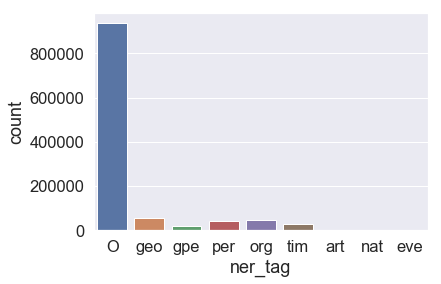

In [28]:
sns.countplot('ner_tag', data=tagged_texts_as_pd_f_add_f)
plt.show()

In [74]:
tagged_texts_as_pd_f_add_f.ner_tag.value_counts()

O      936477
geo     55427
org     44407
per     43118
tim     29799
gpe     19685
art       787
eve       575
nat       280
Name: ner_tag, dtype: int64

## Words distribution across sense numbers

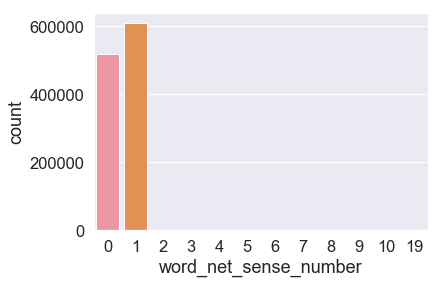

In [29]:
sns.countplot('word_net_sense_number', data=tagged_texts_as_pd_f_add_f)
plt.show()

## Words distribution across POS-tags

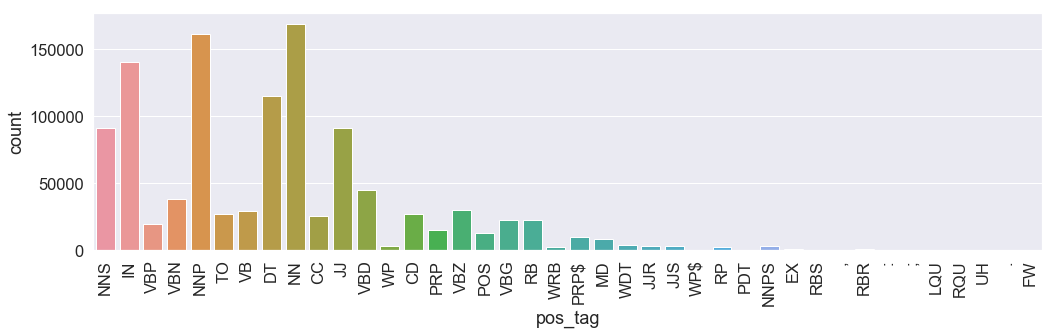

In [30]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos_tag', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across semantic relation prepositions

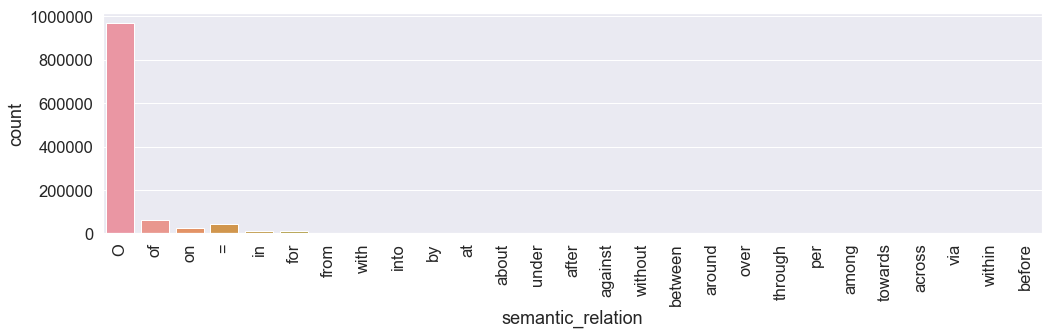

In [31]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('semantic_relation', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across animacy-tags

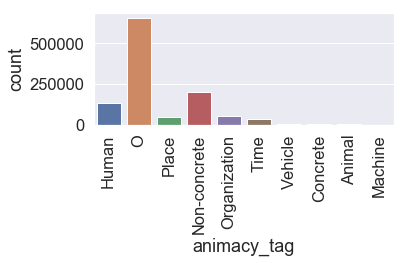

In [32]:
ax = sns.countplot('animacy_tag', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Words distributions (separated by each NER-tag)

## Words distribution across sense numbers

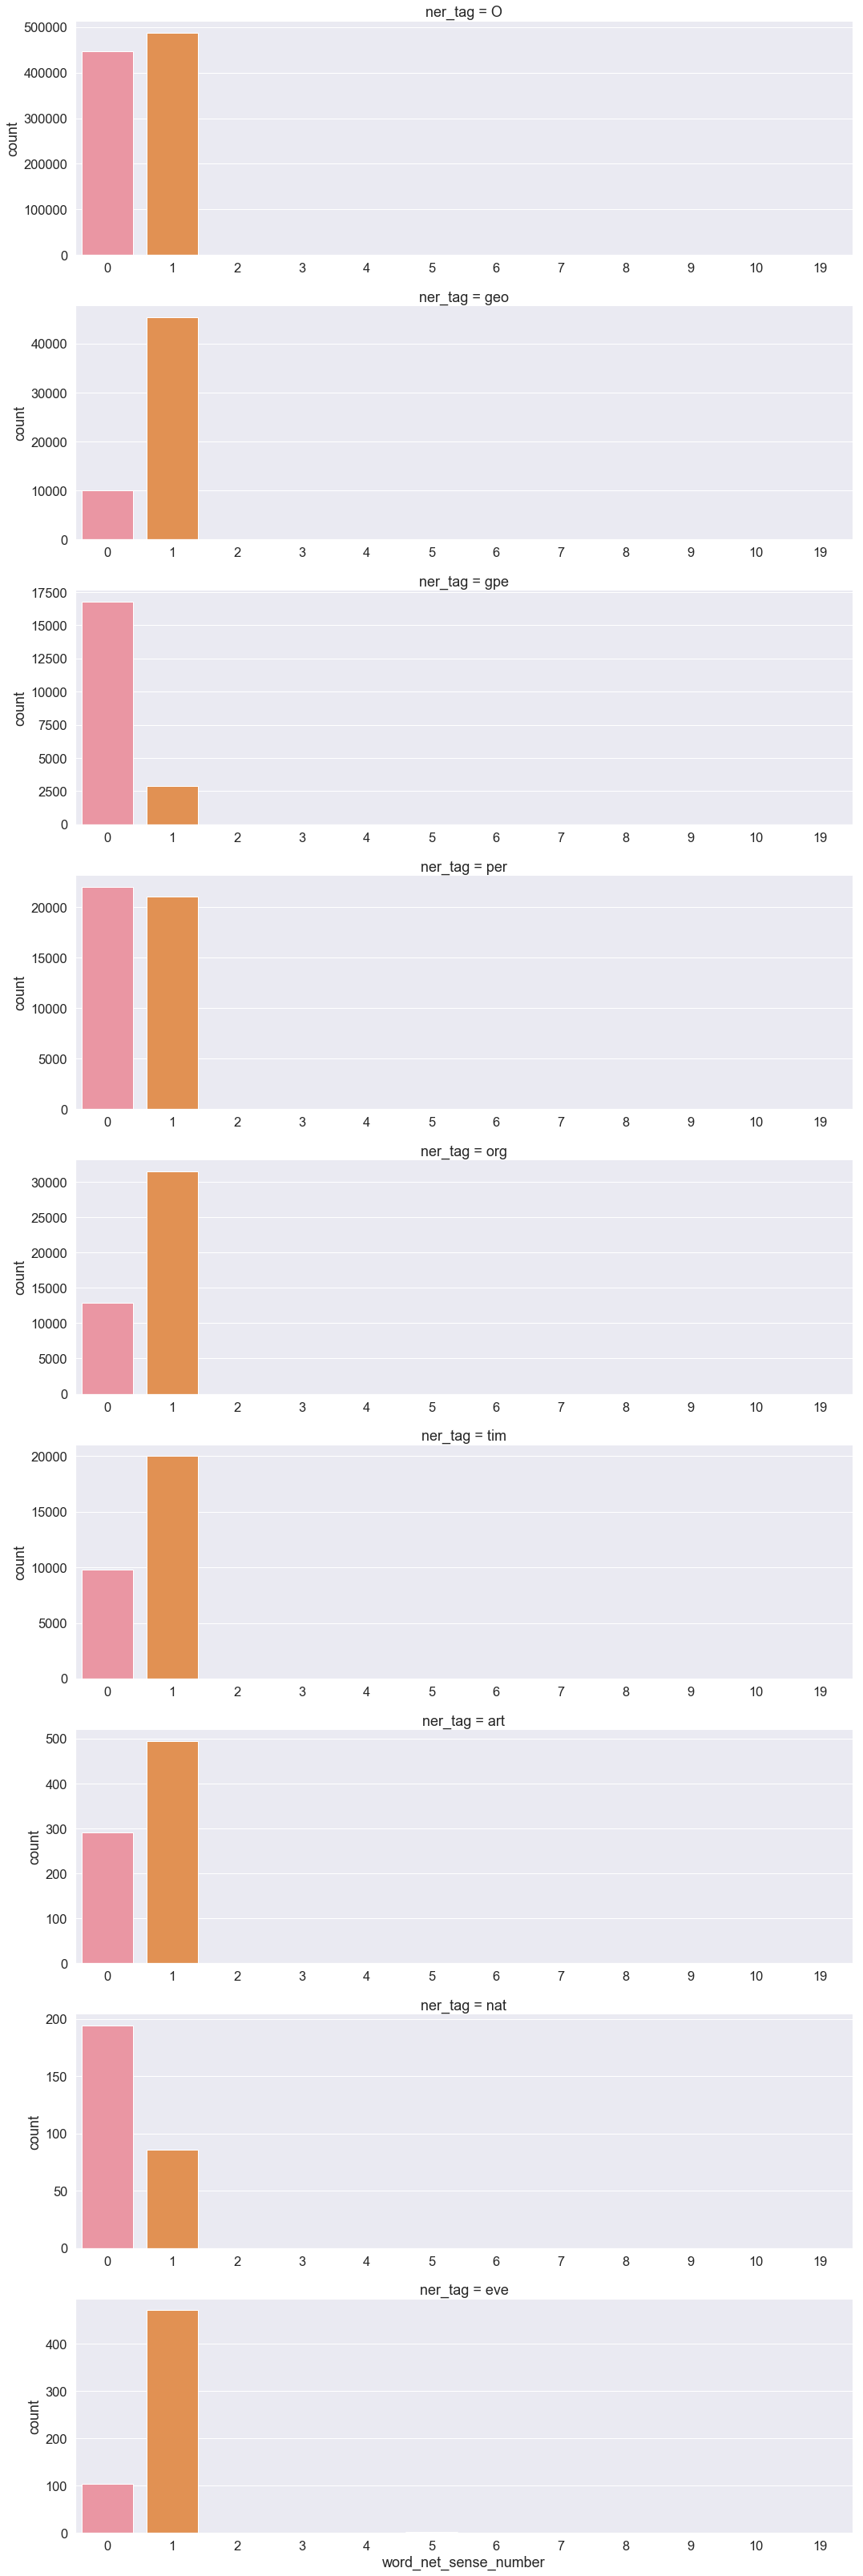

In [63]:
sns.catplot('word_net_sense_number', col='ner_tag', data=tagged_texts_as_pd_f_add_f, kind="count", orient='h', col_wrap=1, sharex=False, sharey=False, aspect=3)
plt.show()

## Words distribution across POS-tags

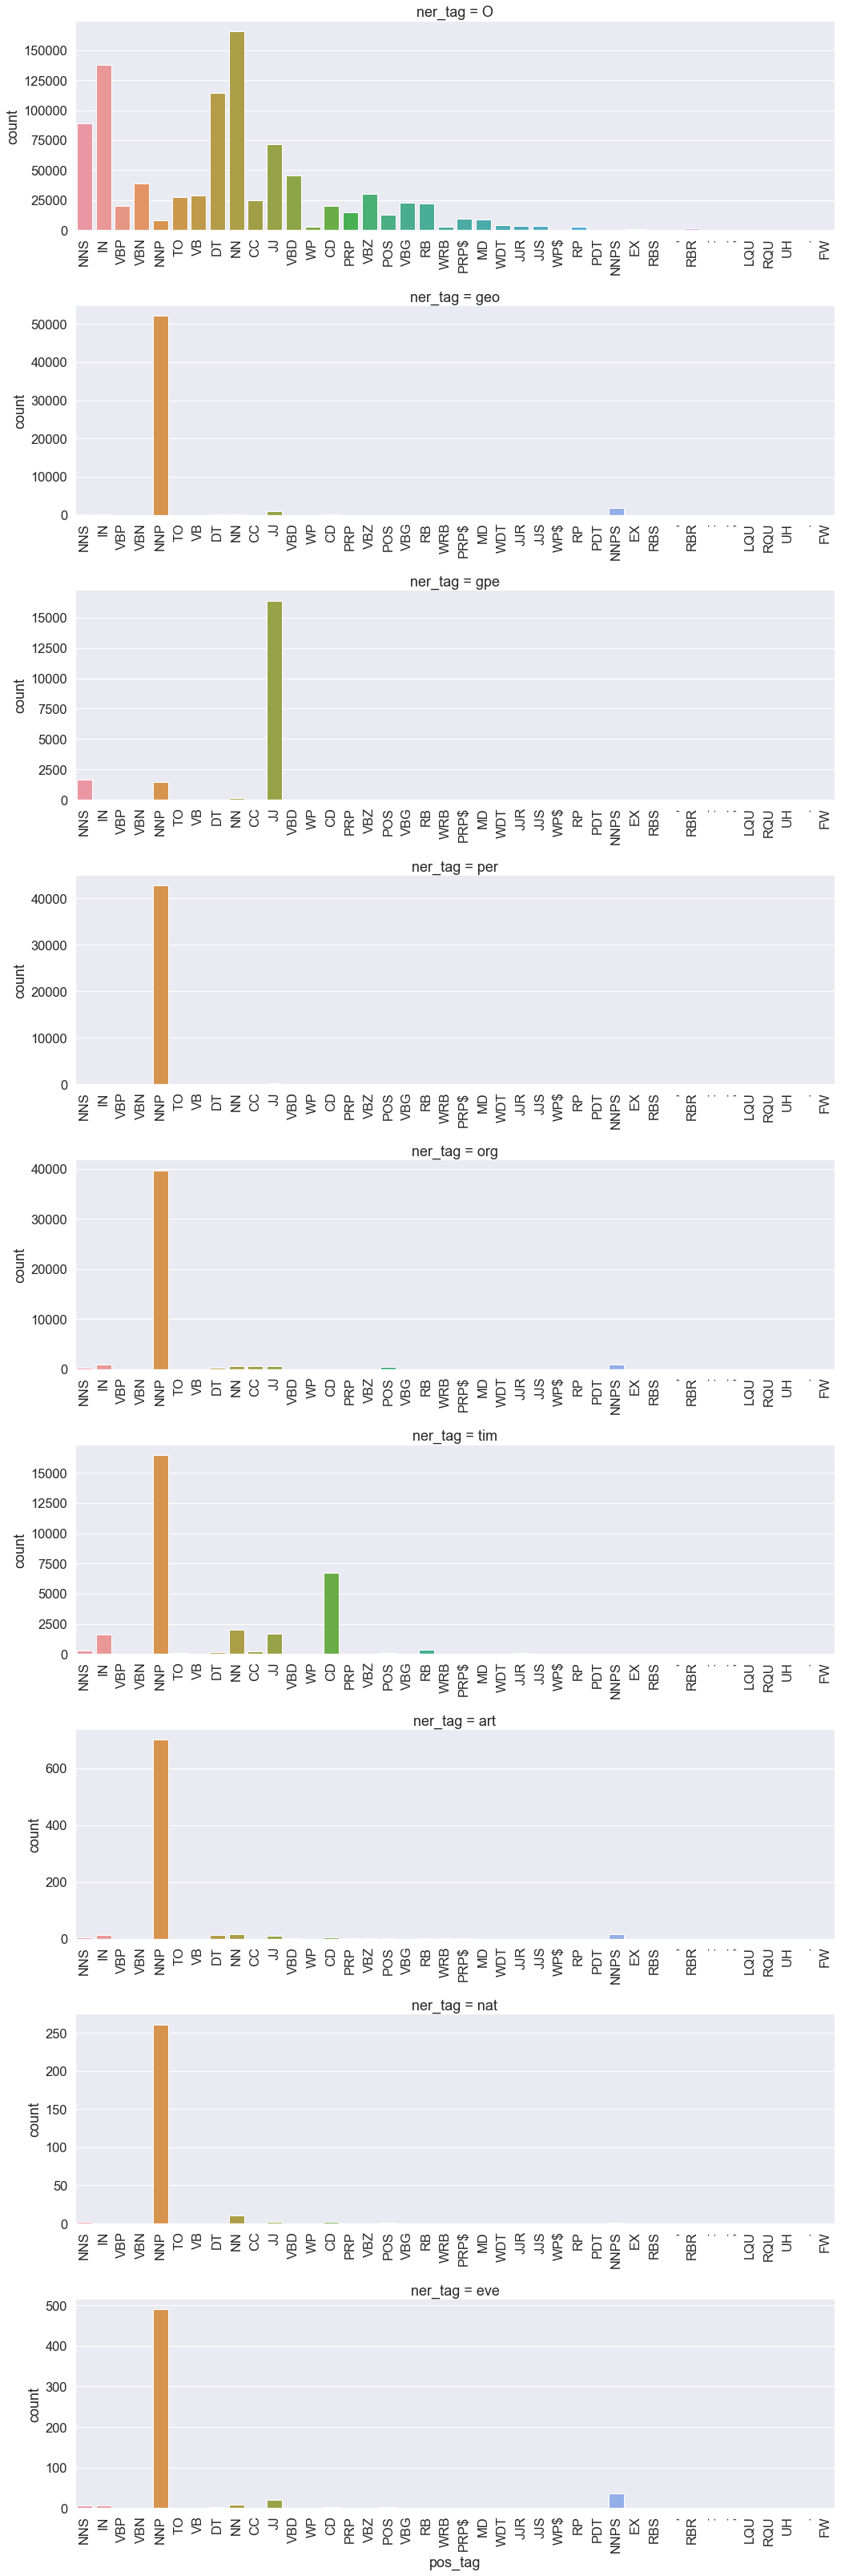

In [69]:
g = sns.catplot('pos_tag', col='ner_tag', data=tagged_texts_as_pd_f_add_f, kind="count", orient='h', col_wrap=1, sharex=False, sharey=False, aspect=3)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across semantic relation prepositions

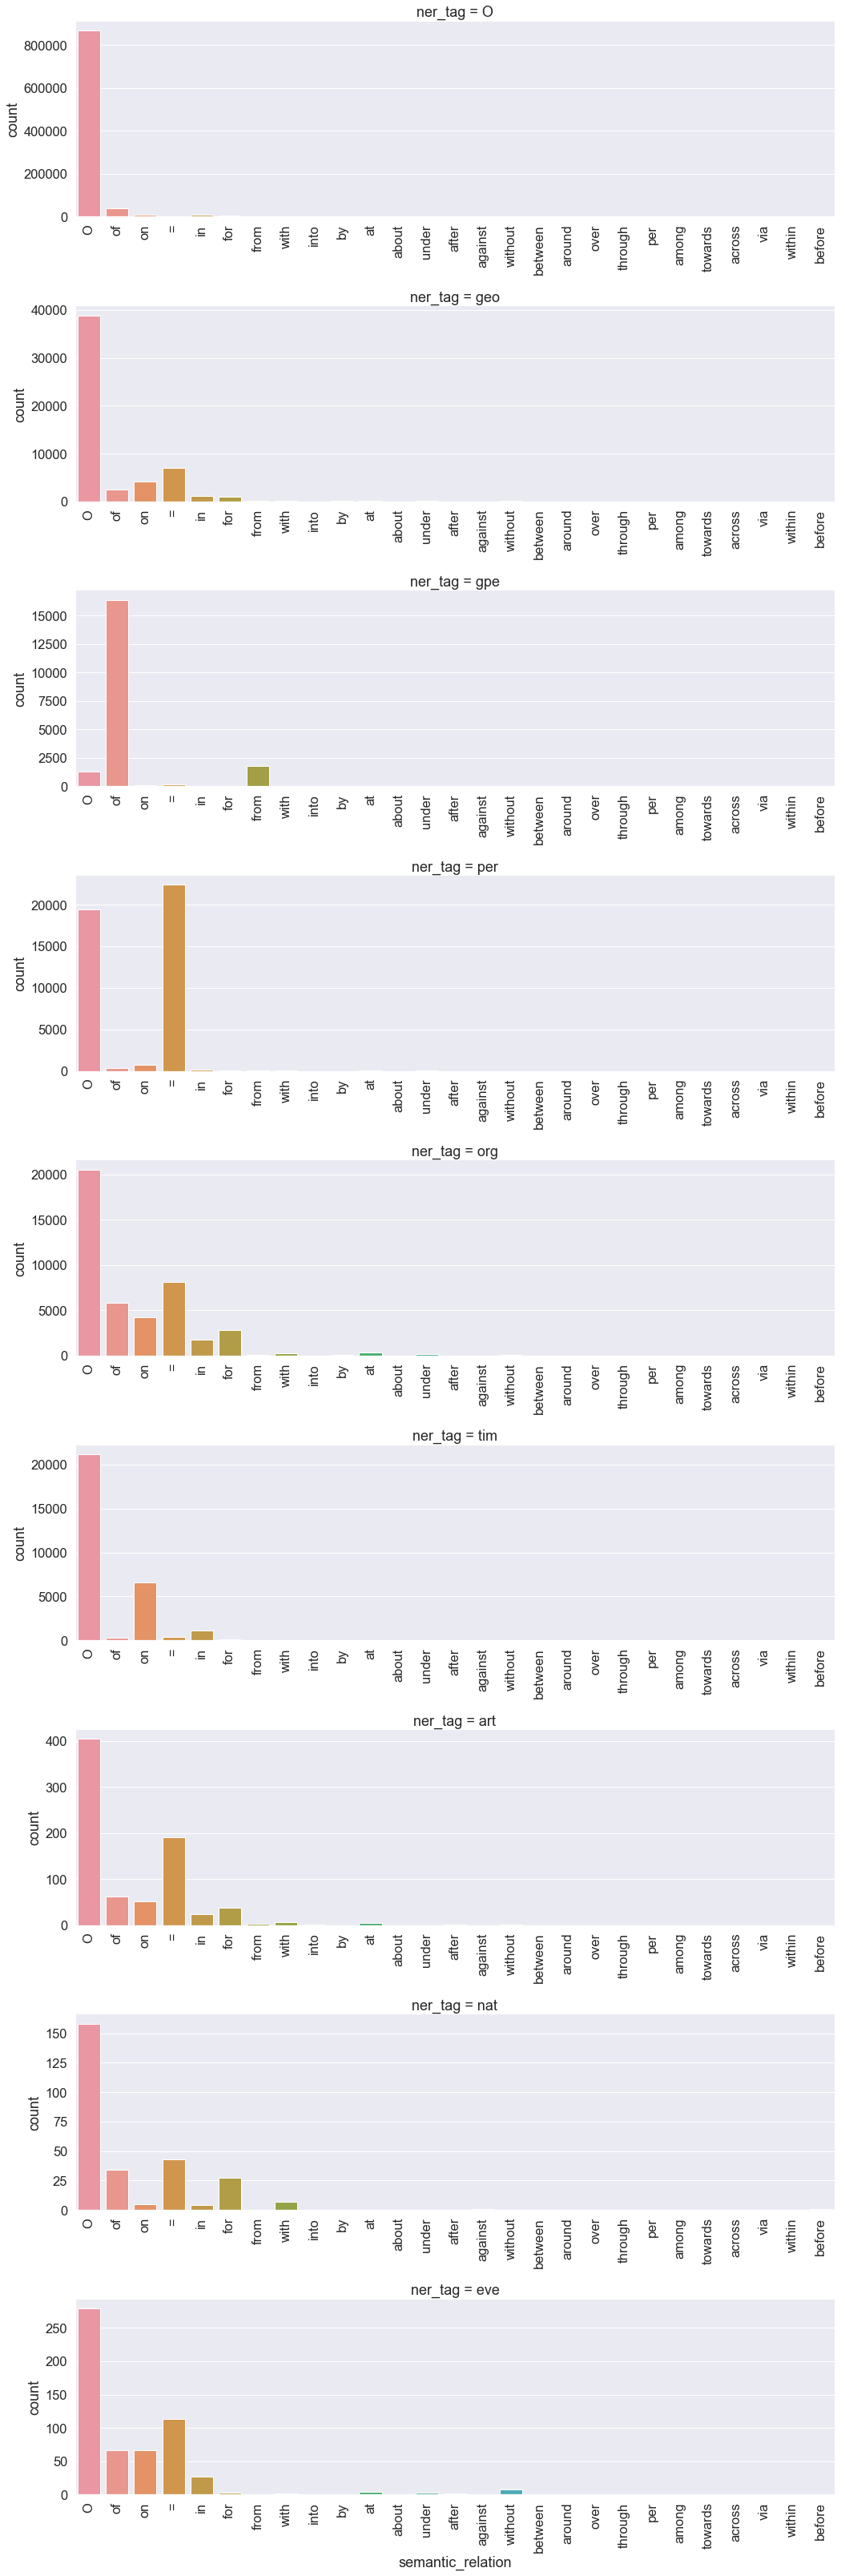

In [72]:
g = sns.catplot('semantic_relation', col='ner_tag', data=tagged_texts_as_pd_f_add_f, kind="count", orient='h', col_wrap=1, sharex=False, sharey=False, aspect=3)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across animacy-tags

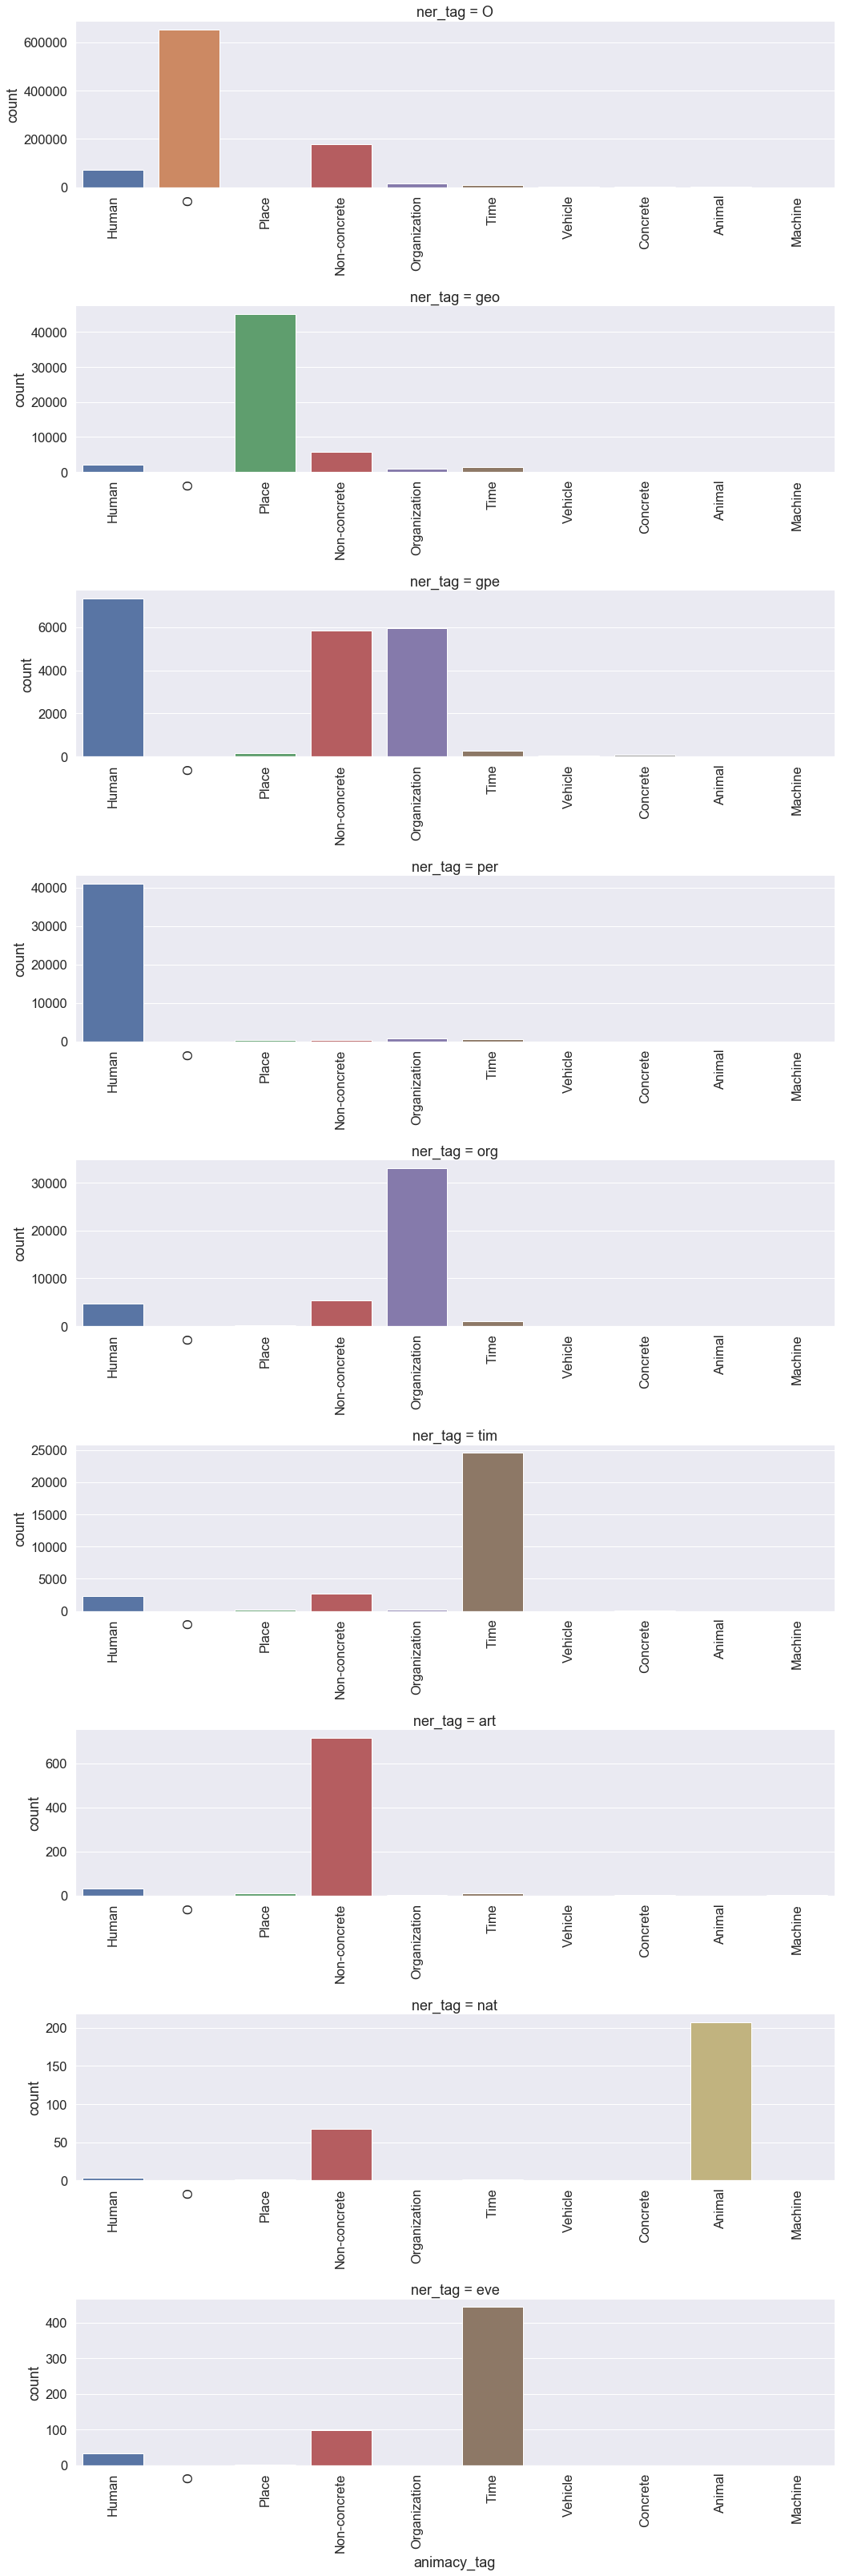

In [73]:
g = sns.catplot('animacy_tag', col='ner_tag', data=tagged_texts_as_pd_f_add_f, kind="count", orient='h', col_wrap=1, sharex=False, sharey=False, aspect=3)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across word lengths

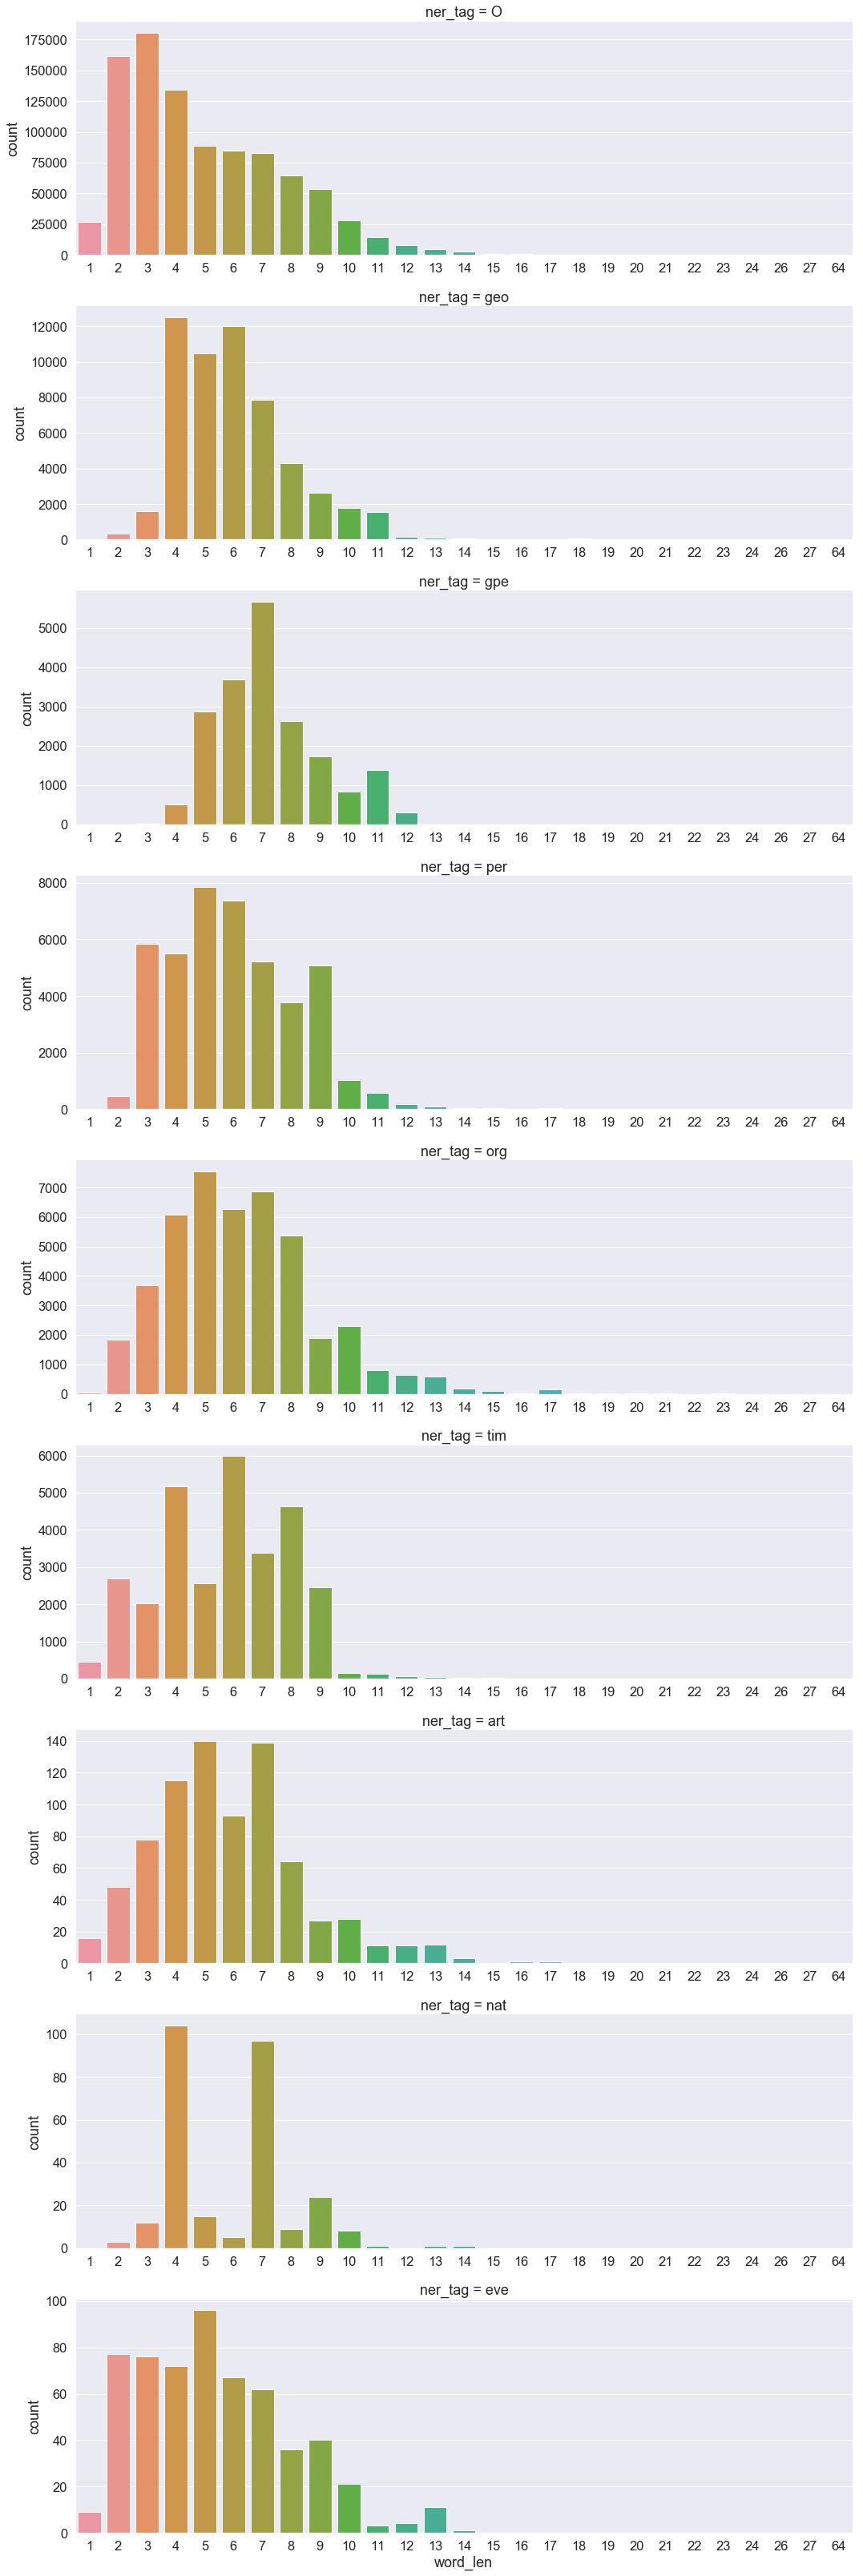

In [56]:
sns.catplot('word_len', col='ner_tag', data=tagged_texts_as_pd_f_add_f, kind="count", orient='h', col_wrap=1, sharex=False, sharey=False, aspect=3)
plt.show()

## Words distribution across semantic relation existence

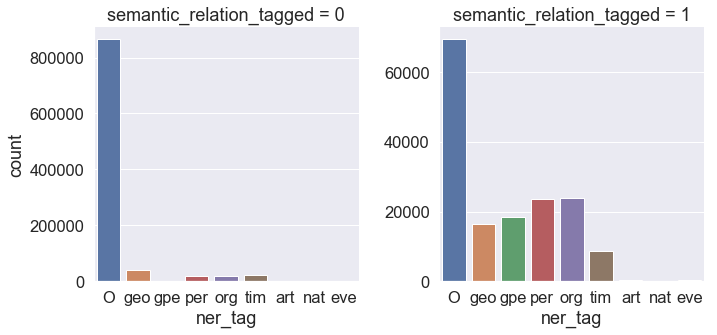

In [55]:
sns.catplot('ner_tag', col='semantic_relation_tagged', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

## Words distribution across animacy tag existence

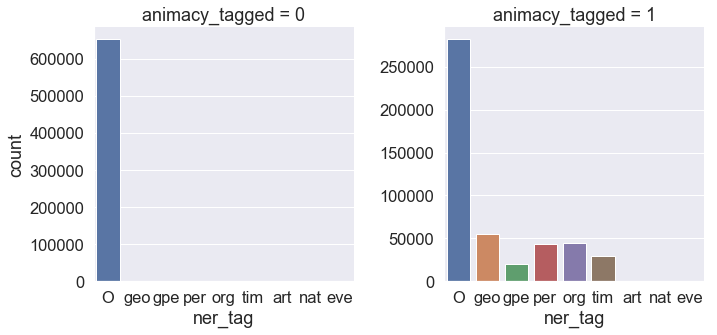

In [54]:
sns.catplot('ner_tag', col='animacy_tagged', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

## Words distribution across word sense existence

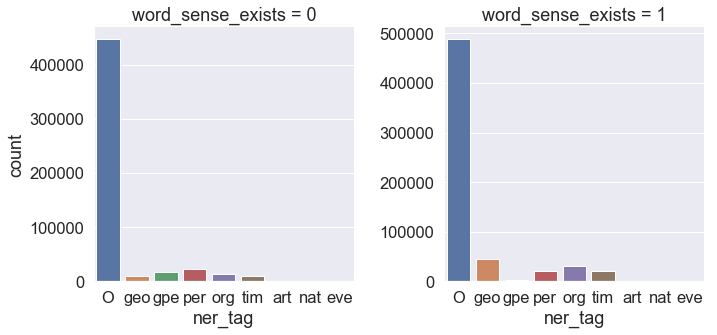

In [53]:
sns.catplot('ner_tag', col='word_sense_exists', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

## Words distribution across NER-tags (for titled and not titled words)

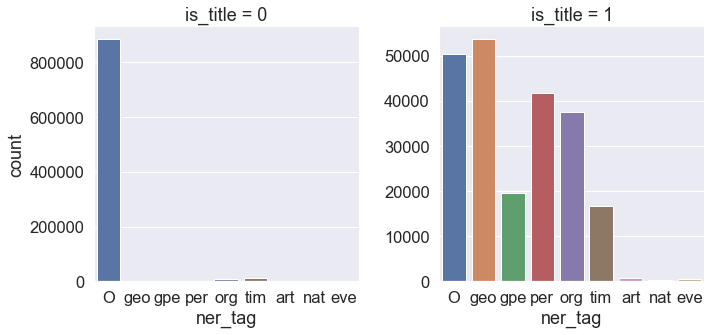

In [52]:
sns.catplot('ner_tag', col='is_title', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

## Words distribution across NER-tags (for words with and without digits)

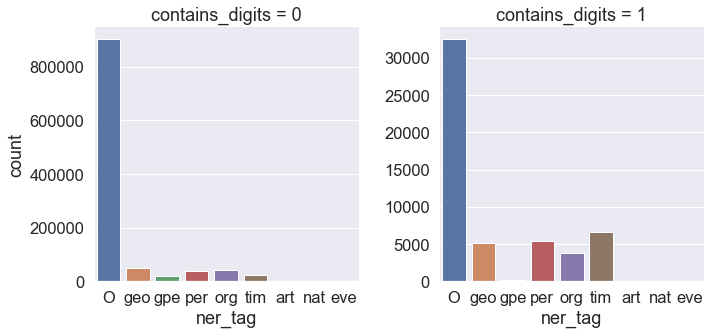

In [51]:
sns.catplot('ner_tag', col='contains_digits', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

## Distribution of lambda-DSR mean lengths across NER-tags

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


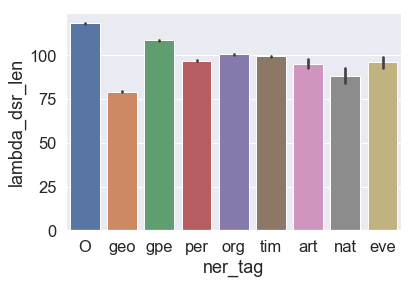

In [38]:
sns.barplot("ner_tag", "lambda_dsr_len", data=tagged_texts_as_pd_f_add_f)
plt.show()

## Distribution of word mean lengths across NER-tags

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


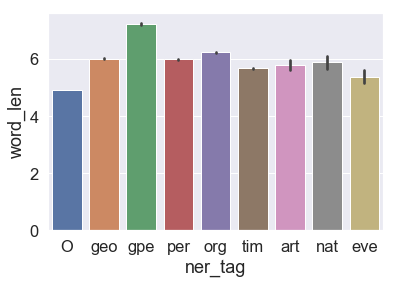

In [39]:
sns.barplot("ner_tag", "word_len", data=tagged_texts_as_pd_f_add_f)
plt.show()